In [2]:
# OpenAI Gym
import retro
import numpy as np
from gym import core, spaces

# Rendering tools
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from IPython.display import clear_output
from xvfbwrapper import Xvfb
vdisplay = Xvfb()
vdisplay.start()

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

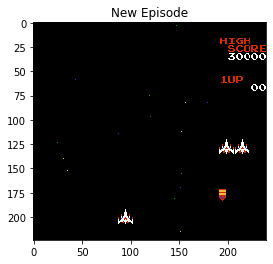

In [3]:
env = retro.make(game='GalagaDemonsOfDeath-Nes', use_restricted_actions=retro.Actions.DISCRETE)


# Reinitialize the environment for an episode
observation = env.reset()

# Look at the features the agent will observe during training...
display(observation)

# Render the scene for our visualization purposes...
plt.imshow(env.render(mode='rgb_array'))
plt.title("New Episode") 
plt.show()

In [4]:
# Shape of the observation vectors
display(env.observation_space.shape)
x_train = env.observation_space.shape
# Number of possible actions
display(env.action_space.n)
y_train = env.observation_space.shape

(224, 240, 3)

36

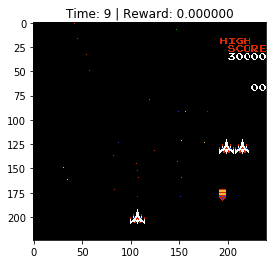

In [5]:
# Initialize the environment and perform 5 random actions
env.reset()
reward = 0.0
env.action_space = spaces.Discrete(16)
i = 8 
j = 0
for time in range(10):
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Time: %d | Reward: %f" % (time, reward))
    clear_output(wait=True)
    display(plt.gcf())
    print(env.action_space.sample())
    observation, reward, done, info = env.step(i) # take a random action
    print(i)
    if (done):
        break
    if j == 20:
        j = 0
        i += 1
    j += 1
clear_output(wait=True)

In [6]:
import keras
import numpy as np

# A simple multilayer architecture....
def make_model(state_size,action_size):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(4, kernel_size=(2, 2), activation='relu', input_shape=state_size))
    model.add(keras.layers.Conv2D(16, (2, 2), activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(3, activation='relu'))
    model.add(keras.layers.Dense(action_size, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
    return model

model = make_model(env.observation_space.shape,env.action_space.n)
model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 239, 4)       52        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 222, 238, 16)      272       
_________________________________________________________________
flatten_1 (Flatten)          (None, 845376)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 2536131   
_________________________________________________________________
dense_2 (Dense)              (None, 16)                64        
Total params: 2,536,519
Trainable params: 2,536,519
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Turn our observation vector into a matrix of observations
# with only -one- observation and run predict()
Q = model.predict(np.expand_dims(observation,axis=0))
Q

array([[3.5261382e-05, 9.2623504e-03, 4.2406961e-04, 2.7491788e-08,
        4.9887900e-04, 1.7083437e-05, 8.8315734e-05, 3.4791484e-02,
        1.4308912e-01, 3.3938186e-08, 4.0688803e-05, 2.5188991e-01,
        4.9548817e-05, 4.2764813e-07, 5.5981278e-01, 6.8670616e-08]],
      dtype=float32)

In [8]:
np.argmax(Q)

14

In [9]:
# Example e-soft policy...
epsilon = 0.5 
# Half of the time, a random action is chosen...
action = np.random.choice(env.action_space.n) if np.random.random() < epsilon else np.argmax(Q)
action

14

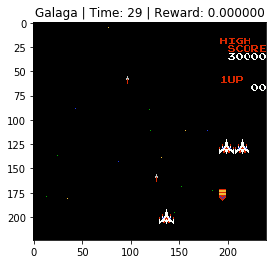

In [13]:
# Initialize the environment and let the agent decide!
observation = env.reset()
epsilon = 0.0 # No exploration!
reward = 0.0
for time in range(30):
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Galaga | Time: %d | Reward: %f" % (time, reward))
    clear_output(wait=True)
    display(plt.gcf())
    Q = model.predict(np.expand_dims(observation,axis=0)) # Compute Q
    action = env.action_space.sample() if np.random.random() < epsilon else np.argmax(Q)
    print(action)
    observation, reward, done, info = env.step(action) # take action!
    if (done):
        break
clear_output(wait=True)

In [14]:
# Step 1 - Replay Memory Class
class ReplayMemory:
    def __init__(self, memory_size, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.size = 0
        self.maxsize = memory_size
        self.current_index = 0
        self.current_state = np.zeros([memory_size,env.observation_space.shape[0], env.observation_space.shape[1], env.observation_space.shape[2]])
        self.action = [0]*memory_size # Remember, actions are integers...
        self.reward = np.zeros([memory_size])
        self.next_state = np.zeros([memory_size,env.observation_space.shape[0], env.observation_space.shape[1], env.observation_space.shape[2]])
        self.done = [False]*memory_size # Boolean (terminal transition?)

    def remember(self, current_state, action, reward, next_state, done):
        # Stores a single memory item
        self.current_state[self.current_index,:,:] = current_state
        self.action[self.current_index] = action
        self.reward[self.current_index] = reward
        self.next_state[self.current_index,:,:] = next_state
        self.done[self.current_index] = done
        self.current_index = (self.current_index+1)%self.maxsize
        self.size = max(self.current_index,self.size)
    
    def replay(self, model, target_model, num_samples, sample_size, gamma):
        # Run replay!
        
        # Can't train if we don't yet have enough samples to begin with...
        if self.size < sample_size:
            return
        
        for i in range(num_samples):
            # Select sample_size memory indices from the whole set
            current_sample = np.random.choice(self.size,sample_size,replace=False)
            
            # Slice memory into training sample
            current_state = self.current_state[current_sample,:,:]
            action = [self.action[j] for j in current_sample]
            reward = self.reward[current_sample]
            next_state = self.next_state[current_sample,:,:]
            done = [self.done[j] for j in current_sample]
            
            # Obtain model's current Q-values
            model_targets = model.predict(current_state)
            
            # Create targets from argmax(Q(s+1,a+1))
            # Use the target model!
            targets = reward + gamma*np.amax(target_model.predict(next_state))
            # Absorb the reward on terminal state-action transitions
            targets[done] = reward[done]
            # Update just the relevant parts of the model_target vector...
            model_targets[range(sample_size),action] = targets
            
            # Update the weights accordingly
            model.fit(current_state,model_targets,
                     epochs=1,verbose=0,batch_size=sample_size)
            
        # Once we have finished training, update the target model
        target_model.set_weights(model.get_weights())

In [15]:
# Full setup for the task...

# For keeping track of performance
from collections import deque

# Hyperparameters
gamma = 0.95
epsilon = 1.0
epsilon_decay = 0.9
epsilon_min = 0.01
episodes = 5

replay_iterations = 100
replay_sample_size = 256

# Peformance stats
times_window = deque(maxlen=100)
mean_times = deque(maxlen=episodes)

env.close()
# Initialize the environment and agent data structures
env = retro.make(game='GalagaDemonsOfDeath-Nes', use_restricted_actions=retro.Actions.DISCRETE)

model = make_model(env.observation_space.shape,env.action_space.n)
target_model = make_model(env.observation_space.shape,env.action_space.n)
memory = ReplayMemory(250,env.observation_space.shape,env.action_space.n)

In [ ]:
# Perform the training!
for episode in range(episodes):
    current_state = env.reset()
    for time in range(2500):
        Q = model.predict(np.expand_dims(current_state,axis=0)) # Compute Q
        action = env.action_space.sample() if np.random.random() < epsilon else np.argmax(Q)
        next_state, reward, done, info = env.step(action) # take action!
        if done:
            reward = -10.0
        memory.remember(current_state,action,reward,next_state,done) # Store in memory...
        current_state = next_state # Transition to next state!
        if (done):
            break
    epsilon = epsilon * epsilon_decay if epsilon > epsilon_min else epsilon_min
    times_window.append(time)
    mean_time = np.mean(times_window)
    mean_times.append(mean_time)
    print('\rEpisode %d/%d - time: %d, mean-time: %d, epsilon: %f'%(episode+1,episodes,time,mean_time,epsilon),end='')
    
    # Training...
    memory.replay(model,target_model,replay_iterations,replay_sample_size,gamma)
print()

In [ ]:
# Plot results
plt.plot(mean_times)
plt.title("Cart-pole Q-Learning Performance")
plt.xlabel("Episode Number")
plt.ylabel("Average # Steps [N=100]")
plt.show()

In [ ]:
# Test out the agent!
# Initialize the environment and let the agent decide how to act!
observation = env.reset()
for time in range(2500):
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Time: %d | Reward: %f" % (time, reward))
    clear_output(wait=True)
    display(plt.gcf())
    Q = model.predict(np.expand_dims(observation,axis=0)) # Compute Q
    action = np.argmax(Q)
    observation, reward, done, info = env.step(action) # take action!
    if (done):
        break
clear_output(wait=True)

In [ ]:
# Stop the Xvfb (used for rendering above)
vdisplay.stop()